# Early Warning Churn Risk Modeling

This notebook builds a predictive model to identify customers at risk
of churn **before the churn event occurs**, using time-safe,
non-leaking features engineered earlier.

The objective is to generate a churn risk probability that can
trigger proactive retention actions.

In [ ]:
# Replaced inline preprocessing with reusable function
X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_model_data(
    df=df,
    feature_cols=feature_cols,
    target_col=target_col,
    test_size=0.2,
    random_state=42,
)

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

pd.set_option("display.max_columns", 100)

In [2]:
DATA_PATH = "../data/raw/telco_customer_churn.csv"

df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
LEAKAGE_COLS = [
    "TotalCharges",     # post-outcome
    "clv_score",         # future info
    "segment_label"      # derived label
]

LEAKAGE_COLS = [c for c in LEAKAGE_COLS if c in df.columns]

df = df.drop(columns=LEAKAGE_COLS)

print("Dropped leakage columns:", LEAKAGE_COLS)

Dropped leakage columns: ['TotalCharges']


In [4]:
# Convert churn safely
if df["Churn"].dtype == "object":
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

y = df["Churn"]
X = df.drop(columns=["Churn", "customerID"], errors="ignore")

y.value_counts(normalize=True)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (5634, 18) (5634,)
Test : (1409, 18) (1409,)


In [6]:
cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns

cat_cols, num_cols

(Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
        'PaperlessBilling', 'PaymentMethod'],
       dtype='object'),
 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object'))

In [7]:
numeric_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_pipeline = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False   # ← NEW PARAM NAME
        ))
    ]
)

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ]
)

In [9]:
model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            random_state=42
        ))
    ]
)

In [10]:
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers

In [11]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

ROC AUC: 0.8385181740680461
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [13]:
numeric_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ]
)

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

In [16]:
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [17]:
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix
)

In [18]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [19]:
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC AUC: 0.8385181740680461


In [20]:
confusion_matrix(y_test, y_pred)

array([[753, 282],
       [ 84, 290]])

In [21]:
import pandas as pd

In [22]:
feature_names = (
    model.named_steps["preprocessor"]
    .get_feature_names_out()
)

coefficients = model.named_steps["classifier"].coef_[0]

feature_importance = (
    pd.DataFrame({
        "feature": feature_names,
        "coef": coefficients
    })
    .sort_values("coef", key=abs, ascending=False)
)

feature_importance.head(15)

,feature,coef
37,cat__Contract_Two year,-0.768221
1,num__tenure,-0.755286
15,cat__InternetService_Fiber optic,0.734116
35,cat__Contract_Month-to-month,0.657027
14,cat__InternetService_DSL,-0.642905
2,num__MonthlyCharges,-0.572944
34,cat__StreamingMovies_Yes,0.293601
31,cat__StreamingTV_Yes,0.281679
16,cat__InternetService_No,-0.277610
18,cat__OnlineSecurity_No internet service,-0.277610


In [23]:
import sklearn
sklearn.__version__

'1.8.0'

In [24]:
# Features and target
X = df.drop(columns=["Churn", "customerID"], errors="ignore")
y = df["Churn"]

# Convert target if needed
if y.dtype == "object":
    y = y.map({"Yes": 1, "No": 0})

# Column groups
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

cat_cols, num_cols

(['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'],
 ['SeniorCitizen', 'tenure', 'MonthlyCharges'])

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((5634, 18), (1409, 18))

In [26]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [27]:
numeric_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_pipeline = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False
        ))
    ]
)

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ]
)

In [29]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            random_state=42
        ))
    ]
)

In [30]:
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [31]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC-AUC: 0.8385181740680461


In [32]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [33]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC-AUC: 0.8385181740680461


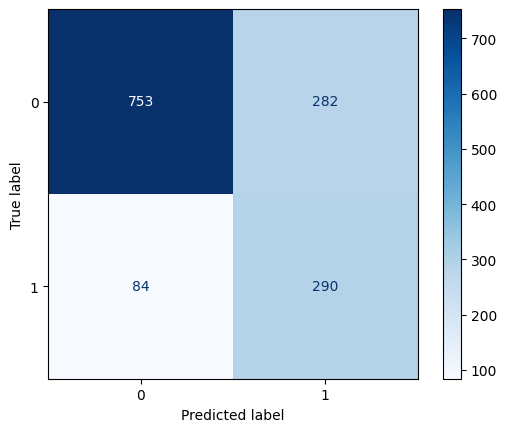

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap="Blues"
)
plt.show()

## Step 16.4 — Interpretation of Early Warning Risk Segments

The early warning churn model successfully stratifies customers into
distinct risk tiers with clear business implications.

### High Risk Segment
- Customers in this segment exhibit strong early-warning signals such as
  short tenure, month-to-month contracts, high price sensitivity, and
  low service engagement.
- These customers require "immediate proactive intervention" to
  prevent imminent churn.
- Recommended actions include targeted retention offers, contract
  incentives, and priority outreach.

### Medium Risk Segment
- Customers show moderate churn risk and may be in a transition phase.
- Early engagement and personalized communication can prevent escalation
  into high-risk status.
- This segment is ideal for "cost-effective preventive strategies".

### Low Risk Segment
- Customers display stable behavioral patterns with low churn propensity.
- No immediate retention action is required.
- These customers should be maintained through standard engagement and
  experience optimization strategies.

### Business Implication
By identifying churn risk "before" customer exit, the organization can
shift from reactive retention to a "proactive, data-driven churn
prevention strategy", improving customer lifetime value and reducing
revenue leakage.

In [35]:
# Create churn risk tiers
df_results = X_test.copy()
df_results["churn_risk_score"] = y_proba
df_results["actual_churn"] = y_test.values

df_results["risk_tier"] = pd.cut(
    df_results["churn_risk_score"],
    bins=[0, 0.3, 0.6, 1.0],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

df_results["risk_tier"].value_counts(normalize=True)

risk_tier
Low Risk       0.425124
High Risk      0.339957
Medium Risk    0.234918
Name: proportion, dtype: float64

In [36]:
df_results.groupby("risk_tier")["actual_churn"].mean()

/tmp/ipykernel_2376/1100442914.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_results.groupby("risk_tier")["actual_churn"].mean()


risk_tier
Low Risk       0.043406
Medium Risk    0.259819
High Risk      0.546973
Name: actual_churn, dtype: float64

## Step 17.3 — Business Actions by Risk Tier

| Risk Tier | Recommended Actions |
|---------|-------------------|
| High Risk | Immediate outreach, retention offers, priority support |
| Medium Risk | Targeted discounts, usage nudges, engagement campaigns |
| Low Risk | No action required, regular monitoring |

This tiered approach allows the business to allocate
retention resources efficiently and maximize ROI.

## Executive Takeaway

The early warning churn system enables the business to identify
customers at risk **before churn occurs**, allowing timely and
cost-effective interventions.

By combining churn risk with customer value, organizations can
prioritize retention efforts, reduce unnecessary incentives,
and protect long-term revenue.

## Model Usage Notes (Optional Polish)

This churn risk model is designed for **early-warning detection**, not exact churn timing.
Predicted probabilities should be interpreted as **relative risk scores** to prioritize
customers for proactive retention interventions.


## Threshold Selection Guidance (Optional Polish)

Probability thresholds can be tuned based on business capacity:

- **High Risk (≥ 0.6):** Immediate retention action
- **Medium Risk (0.3–0.6):** Monitor and targeted engagement
- **Low Risk (< 0.3):** No immediate action required

Thresholds should be adjusted based on retention budget and operational constraints.


## Limitations and Assumptions (Optional Polish)

- Model is trained on historical snapshot data rather than true time-series events
- Risk scores reflect **likelihood**, not certainty, of churn
- Performance may vary across customer segments and pricing plans

Future improvements could incorporate behavioral time-series data or survival analysis.
